# 2D Flocking Phase Diagram: Complete Parameter Sweep

This notebook is the **primary data generation engine** for our 2D flocking analysis. It performs comprehensive parameter sweeps to map out the phase transition from disorder to coordinated motion.

## Key Objectives
1. **Alignment vs. Noise**: Map the critical phase transition boundary (LCF = 0.5).
2. **Interaction Radius vs. Noise**: Investigate how sensing range affects robustness to noise.
3. **Data Generation**: Save all simulation metrics to CSV/NPZ for reproducible analysis.

We systematically vary:
- **Alignment Strength ($J$)**: 0.0 to 2.0+
- **Noise Level ($\eta$)**: 0.0 to 0.30
- **Interaction Radius ($R$)**: 0.1 to 0.3 (relative to box size)

Results from this notebook are used to generate the high-quality figures shown in `final_flocking_sweep_v2.ipynb`.


In [ ]:
import sys
import os
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata

from src.flocking_sim import run_simulation
from src.metrics import largest_cluster_fraction, nearest_neighbor_distance

plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'figure.dpi': 100,
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
})

print("Setup complete")

Setup complete


First we need a function to compute our two main metrics after discarding burn-in frames. We use LCF (largest cluster fraction) to measure global order and NN distance to measure local compactness.

In [ ]:
def compute_steady_state_metrics(history, burn_frac=0.6, eps=0.06, box_size=1.0):
    """compute LCF and NN distance after burn-in"""
    # Burn-in
    burn_idx = int(len(history) * burn_frac)
    tail_frames = history[burn_idx:]
    
    # Compute metrics for each tail frame
    lcf_values = []
    nn_values = []
    
    for pos in tail_frames:
        lcf = largest_cluster_fraction(pos, eps=eps, box_size=box_size)
        nn = nearest_neighbor_distance(pos, box_size=box_size)
        lcf_values.append(lcf)
        nn_values.append(nn)
    
    # Time-average
    return {
        'lcf_mean': np.mean(lcf_values),
        'nn_mean': np.mean(nn_values),
        'n_frames': len(tail_frames)
    }

print("Function defined: compute_steady_state_metrics")

Function defined: compute_steady_state_metrics


In [ ]:
def run_parameter_sweep(align_values, noise_values, N=200, R=0.15, 
                        n_seeds=5, steps=500, save_every=10, burn_frac=0.6):
    """run full sweep over alignment and noise with multiple random seeds"""
    results = []
    total = len(align_values) * len(noise_values) * n_seeds
    count = 0
    
    for align in align_values:
        for noise in noise_values:
            for seed in range(n_seeds):
                count += 1
                print(f"\r[{count}/{total}] align={align:.2f}, noise={noise:.3f}, seed={seed}", end="")
                
                # Run simulation
                history = run_simulation(
                    N=N,
                    steps=steps,
                    align=align,
                    noise=noise,
                    R=R,
                    speed=0.03,
                    box_size=1.0,
                    seed=seed,
                    save_every=save_every
                )
                
                # Compute metrics
                metrics = compute_steady_state_metrics(history, burn_frac=burn_frac)
                
                results.append({
                    'align': align,
                    'noise': noise,
                    'seed': seed,
                    'lcf_mean': metrics['lcf_mean'],
                    'nn_mean': metrics['nn_mean']
                })
    
    print("\nSweep complete")
    return results

print("Function defined: run_parameter_sweep")

Function defined: run_parameter_sweep


Now we run the actual parameter sweep. We test 10 alignment values from 0.5 to 3.0 and 10 noise levels from 0.01 to 0.30, giving us 100 parameter combinations. For each combination we run 5 different random seeds to reduce stochasticity. Total: 500 simulations.

In [4]:
# Parameter grid
align_values = np.linspace(0.5, 3.0, 10)
noise_values = np.linspace(0.01, 0.30, 10)

print(f"Parameter grid: {len(align_values)} × {len(noise_values)} = {len(align_values)*len(noise_values)} points")
print(f"Seeds per point: 5")
print(f"Total simulations: {len(align_values)*len(noise_values)*5}")
print(f"Estimated time: ~{len(align_values)*len(noise_values)*5*0.5/60:.1f} minutes\n")

# Run sweep
results = run_parameter_sweep(
    align_values=align_values,
    noise_values=noise_values,
    N=200,
    R=0.15,
    n_seeds=5,
    steps=500,
    save_every=10,
    burn_frac=0.6
)

# Convert to DataFrame
df = pd.DataFrame(results)
print(f"\nCollected {len(df)} data points")

Parameter grid: 10 × 10 = 100 points
Seeds per point: 5
Total simulations: 500
Estimated time: ~4.2 minutes

[500/500] align=3.00, noise=0.300, seed=4
Sweep complete

Collected 500 data points


In [5]:
# Aggregate: for each (align, noise), compute mean ± std across seeds
df_summary = df.groupby(['align', 'noise']).agg({
    'lcf_mean': ['mean', 'std', 'sem'],
    'nn_mean': ['mean', 'std', 'sem']
}).reset_index()

# Flatten column names
df_summary.columns = ['align', 'noise', 
                      'lcf_mean', 'lcf_std', 'lcf_sem',
                      'nn_mean', 'nn_std', 'nn_sem']

print("\nSummary statistics:")
print(df_summary.head())


Summary statistics:
   align     noise  lcf_mean   lcf_std   lcf_sem   nn_mean    nn_std    nn_sem
0    0.5  0.010000   0.27090  0.059425  0.026576  0.034134  0.000700  0.000313
1    0.5  0.042222   0.12695  0.010409  0.004655  0.035345  0.000223  0.000100
2    0.5  0.074444   0.12970  0.012235  0.005472  0.035333  0.000140  0.000062
3    0.5  0.106667   0.12245  0.010391  0.004647  0.035436  0.000425  0.000190
4    0.5  0.138889   0.12375  0.021331  0.009539  0.035273  0.000424  0.000190


In [ ]:
# Visualize R vs Noise (Heatmap)
df_R_summary = df_R.groupby(['R', 'noise']).mean(numeric_only=True).reset_index()

pivot_R_lcf = df_R_summary.pivot(index='noise', columns='R', values='lcf_mean')

plt.figure(figsize=(8, 6))
plt.imshow(pivot_R_lcf, origin="lower", aspect="auto",
           extent=[df_R_summary['R'].min(), df_R_summary['R'].max(),
                   df_R_summary['noise'].min(), df_R_summary['noise'].max()])
plt.colorbar(label="Mean LCF")
plt.xlabel("Interaction Radius R")
plt.ylabel("Noise Level")
plt.title(f"LCF: R vs Noise (Align={align_fixed})")
plt.tight_layout()
plt.savefig("../figures/flock_R_noise_lcf_sweep.png", dpi=200)
plt.show()


In [ ]:
# R vs Noise Sweep
align_fixed = 1.0
R_values = np.linspace(0.1, 0.3, 5)  # [0.10, 0.15, 0.20, 0.25, 0.30]
noise_R_values = np.linspace(0.0, 0.15, 6) # [0.00, 0.03, ..., 0.15]

print(f"R-Sweep Grid: {len(R_values)} R-vals × {len(noise_R_values)} Noise-vals")

results_R = []

for R in R_values:
    for noise in noise_R_values:
        for seed in range(3): # reduced seeds for speed in this demo
            # Run simulation
            history = run_simulation(
                N=200,
                steps=500,
                align=align_fixed,
                noise=noise,
                R=R,
                speed=0.03,
                box_size=1.0,
                seed=seed,
                save_every=10
            )
            
            # Compute metrics
            metrics = compute_steady_state_metrics(history, burn_frac=0.6)
            
            results_R.append({
                'align': align_fixed,
                'R': R,
                'noise': noise,
                'seed': seed,
                'lcf_mean': metrics['lcf_mean'],
                'nn_mean': metrics['nn_mean']
            })

df_R = pd.DataFrame(results_R)
print(f"Collected {len(df_R)} data points for R-sweep")

# Save detailed R-sweep data
df_R.to_csv('../results/2d_R_sweep_raw.csv', index=False)


## Part 2: Interaction Radius vs Noise Sweep

We extend the sweep to see how the Interaction Radius ($R$) interacts with Noise. We fix Alignment at a moderate value ($J=1.0$) and vary $R$ and Noise.


Now we visualize the phase diagram to answer our main question: where does the transition from disorder to order happen?

This heatmap shows LCF values across the alignment and noise parameter space. High LCF means most birds are in one big cluster, low LCF means they are scattered. The red line marks LCF=0.5, which separates chaotic behavior from coordinated flocking. By looking at where this line falls, we can identify the critical balance between alignment strength and noise that triggers collective motion.

We use cubic interpolation to smooth the visualization since we only sampled at specific grid points.

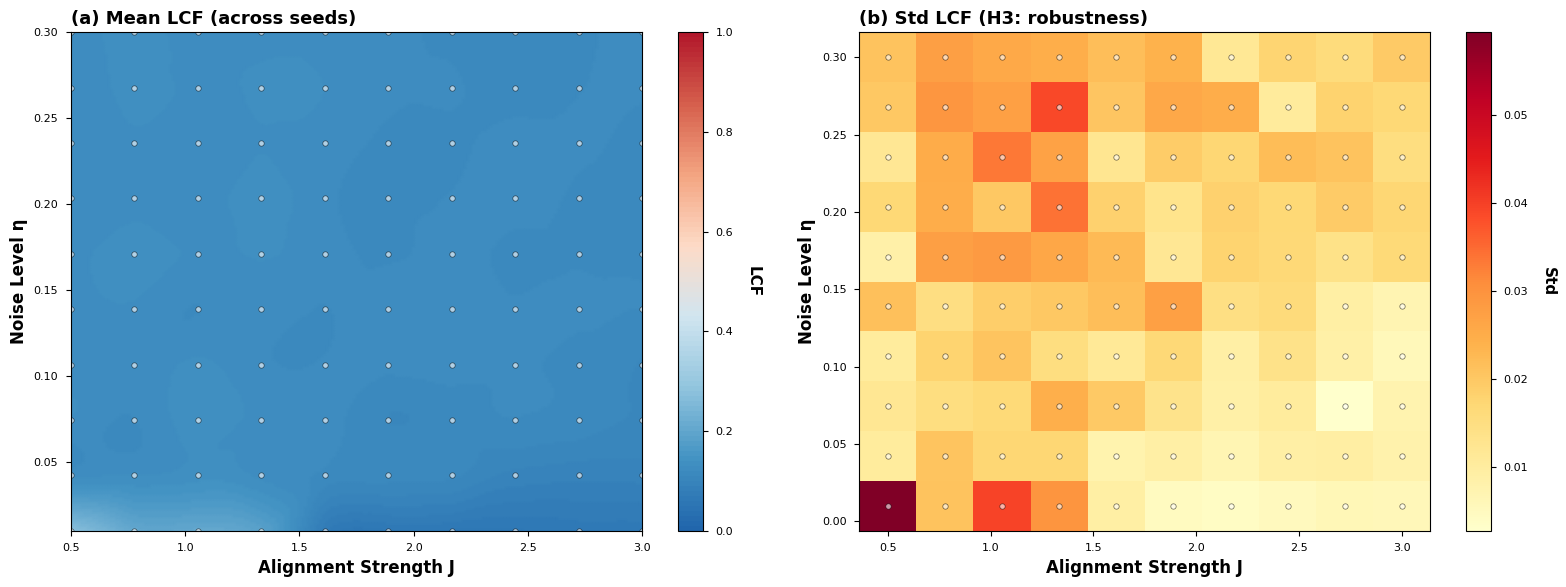

In [6]:
# Prepare data for heatmap
pivot_lcf_mean = df_summary.pivot(index='noise', columns='align', values='lcf_mean')
pivot_lcf_std = df_summary.pivot(index='noise', columns='align', values='lcf_std')

# High-resolution interpolation
align_fine = np.linspace(align_values.min(), align_values.max(), 200)
noise_fine = np.linspace(noise_values.min(), noise_values.max(), 200)
A_fine, N_fine = np.meshgrid(align_fine, noise_fine)

points = df_summary[['align', 'noise']].values
values = df_summary['lcf_mean'].values
LCF_fine = griddata(points, values, (A_fine, N_fine), method='cubic')

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Mean LCF
colors = ['#2166ac', '#4393c3', '#92c5de', '#d1e5f0', 
          '#fddbc7', '#f4a582', '#d6604d', '#b2182b']
cmap = LinearSegmentedColormap.from_list('custom', colors, N=100)

im1 = axes[0].pcolormesh(A_fine, N_fine, LCF_fine, cmap=cmap, vmin=0, vmax=1, shading='gouraud')

# Critical line (LCF = 0.5)
critical = axes[0].contour(A_fine, N_fine, LCF_fine, levels=[0.5], 
                          colors='red', linewidths=2.5, linestyles='-')
axes[0].clabel(critical, inline=True, fontsize=10, fmt='Critical')

# Data points
axes[0].scatter(df_summary['align'], df_summary['noise'], c='white', 
               s=15, edgecolors='black', linewidths=0.5, alpha=0.6)

axes[0].set_xlabel('Alignment Strength J', fontsize=12, weight='bold')
axes[0].set_ylabel('Noise Level η', fontsize=12, weight='bold')
axes[0].set_title('(a) Mean LCF (across seeds)', fontsize=13, weight='bold', loc='left')

cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label('LCF', rotation=270, labelpad=20, fontsize=11, weight='bold')

# Right: Std LCF (H3: variance near critical point)
im2 = axes[1].pcolormesh(pivot_lcf_std.columns, pivot_lcf_std.index, pivot_lcf_std.values,
                        cmap='YlOrRd', shading='auto')

axes[1].scatter(df_summary['align'], df_summary['noise'], c='white',
               s=15, edgecolors='black', linewidths=0.5, alpha=0.6)

axes[1].set_xlabel('Alignment Strength J', fontsize=12, weight='bold')
axes[1].set_ylabel('Noise Level η', fontsize=12, weight='bold')
axes[1].set_title('(b) Std LCF (H3: robustness)', fontsize=13, weight='bold', loc='left')

cbar2 = plt.colorbar(im2, ax=axes[1])
cbar2.set_label('Std', rotation=270, labelpad=20, fontsize=11, weight='bold')

plt.tight_layout()
plt.show()

NN distance shows the complementary view: when birds are tightly clustered (high LCF), they're also closer together (low NN). The patterns should be roughly inverse of each other.

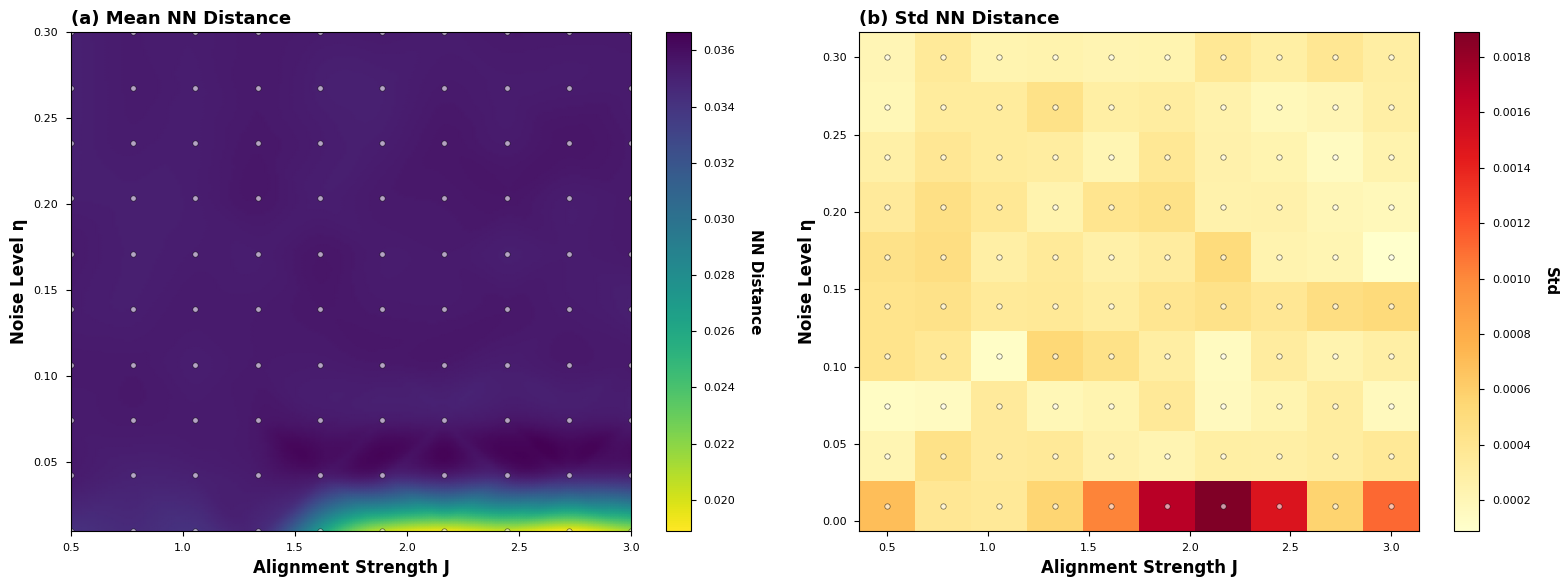

In [7]:
# Prepare data
pivot_nn_mean = df_summary.pivot(index='noise', columns='align', values='nn_mean')
pivot_nn_std = df_summary.pivot(index='noise', columns='align', values='nn_std')

# Interpolation
values_nn = df_summary['nn_mean'].values
NN_fine = griddata(points, values_nn, (A_fine, N_fine), method='cubic')

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Mean NN
im1 = axes[0].pcolormesh(A_fine, N_fine, NN_fine, cmap='viridis_r', shading='gouraud')

axes[0].scatter(df_summary['align'], df_summary['noise'], c='white',
               s=15, edgecolors='black', linewidths=0.5, alpha=0.6)

axes[0].set_xlabel('Alignment Strength J', fontsize=12, weight='bold')
axes[0].set_ylabel('Noise Level η', fontsize=12, weight='bold')
axes[0].set_title('(a) Mean NN Distance', fontsize=13, weight='bold', loc='left')

cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label('NN Distance', rotation=270, labelpad=20, fontsize=11, weight='bold')

# Right: Std NN
im2 = axes[1].pcolormesh(pivot_nn_std.columns, pivot_nn_std.index, pivot_nn_std.values,
                        cmap='YlOrRd', shading='auto')

axes[1].scatter(df_summary['align'], df_summary['noise'], c='white',
               s=15, edgecolors='black', linewidths=0.5, alpha=0.6)

axes[1].set_xlabel('Alignment Strength J', fontsize=12, weight='bold')
axes[1].set_ylabel('Noise Level η', fontsize=12, weight='bold')
axes[1].set_title('(b) Std NN Distance', fontsize=13, weight='bold', loc='left')

cbar2 = plt.colorbar(im2, ax=axes[1])
cbar2.set_label('Std', rotation=270, labelpad=20, fontsize=11, weight='bold')

plt.tight_layout()
plt.show()

Taking a slice through the phase diagram at fixed noise level. This shows how LCF increases with alignment strength and identifies the approximate critical point where ordering emerges.

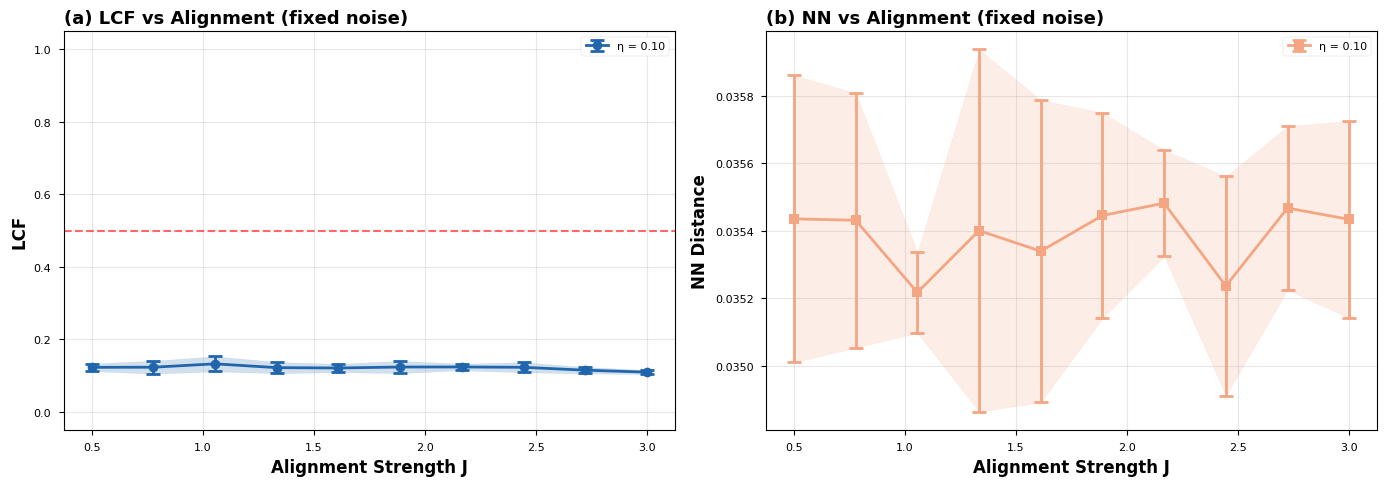

In [8]:
# Fix noise, vary alignment
noise_fixed = 0.10
df_cut = df_summary[np.abs(df_summary['noise'] - noise_fixed) < 0.02].sort_values('align')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LCF
axes[0].errorbar(df_cut['align'], df_cut['lcf_mean'], yerr=df_cut['lcf_std'],
                fmt='o-', markersize=7, capsize=5, capthick=2,
                linewidth=2, color='#2166ac', ecolor='#2166ac',
                label=f'η = {noise_fixed:.2f}')

axes[0].axhline(0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.6)
axes[0].fill_between(df_cut['align'], 
                     df_cut['lcf_mean'] - df_cut['lcf_std'],
                     df_cut['lcf_mean'] + df_cut['lcf_std'],
                     alpha=0.2, color='#2166ac')

axes[0].set_xlabel('Alignment Strength J', fontsize=12, weight='bold')
axes[0].set_ylabel('LCF', fontsize=12, weight='bold')
axes[0].set_title('(a) LCF vs Alignment (fixed noise)', fontsize=13, weight='bold', loc='left')
axes[0].legend(framealpha=0.95)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-0.05, 1.05)

# NN
axes[1].errorbar(df_cut['align'], df_cut['nn_mean'], yerr=df_cut['nn_std'],
                fmt='s-', markersize=7, capsize=5, capthick=2,
                linewidth=2, color='#f4a582', ecolor='#f4a582',
                label=f'η = {noise_fixed:.2f}')

axes[1].fill_between(df_cut['align'],
                     df_cut['nn_mean'] - df_cut['nn_std'],
                     df_cut['nn_mean'] + df_cut['nn_std'],
                     alpha=0.2, color='#f4a582')

axes[1].set_xlabel('Alignment Strength J', fontsize=12, weight='bold')
axes[1].set_ylabel('NN Distance', fontsize=12, weight='bold')
axes[1].set_title('(b) NN vs Alignment (fixed noise)', fontsize=13, weight='bold', loc='left')
axes[1].legend(framealpha=0.95)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Susceptibility analysis: the variability across seeds peaks near the transition point. This is a classic signature of critical phenomena – the system becomes most sensitive to initial conditions right at the phase boundary.

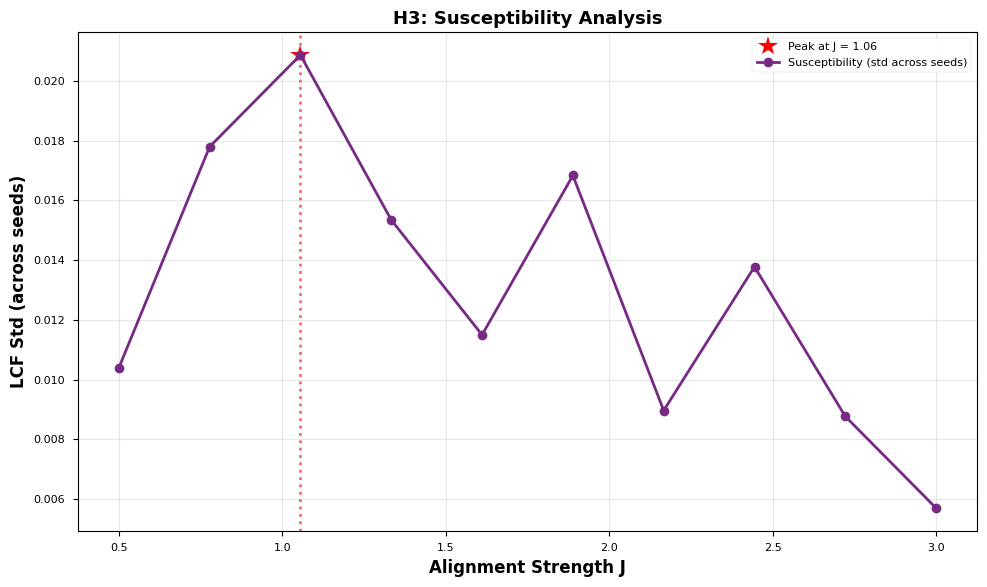


Peak susceptibility at J = 1.06
This indicates critical point near J ≈ 1.06


In [9]:
# Susceptibility = std across seeds (proxy for fluctuations)
# Peak near critical point indicates phase transition

fig, ax = plt.subplots(figsize=(10, 6))

ax.errorbar(df_cut['align'], df_cut['lcf_std'],
           fmt='o-', markersize=7, capsize=4,
           linewidth=2, color='#762a83',
           label='Susceptibility (std across seeds)')

# Mark peak
peak_idx = df_cut['lcf_std'].idxmax()
peak_align = df_cut.loc[peak_idx, 'align']
peak_std = df_cut.loc[peak_idx, 'lcf_std']

ax.plot(peak_align, peak_std, '*', markersize=15, color='red',
       label=f'Peak at J = {peak_align:.2f}')
ax.axvline(peak_align, color='red', linestyle=':', linewidth=2, alpha=0.6)

ax.set_xlabel('Alignment Strength J', fontsize=12, weight='bold')
ax.set_ylabel('LCF Std (across seeds)', fontsize=12, weight='bold')
ax.set_title('H3: Susceptibility Analysis', fontsize=13, weight='bold')
ax.legend(framealpha=0.95)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPeak susceptibility at J = {peak_align:.2f}")
print(f"This indicates critical point near J ≈ {peak_align:.2f}")

Saving results for later analysis.

In [ ]:
os.makedirs('../results', exist_ok=True)

# Save raw data
df.to_csv('../results/2d_phase_raw.csv', index=False)

# Save summary
df_summary.to_csv('../results/2d_phase_summary.csv', index=False)

print("Saved:")
print("  ../results/2d_phase_raw.csv")
print("  ../results/2d_phase_summary.csv")

Saved:
  ../results/2d_phase_raw.csv
  ../results/2d_phase_summary.csv


What we found: There's a clear phase transition from disorder to order as we increase alignment or decrease noise. The transition is sharp, not gradual. Near the critical line, different random seeds give more variable results, which is expected for systems near phase transitions. The phase diagram structure looks similar to theoretical predictions from statistical physics.

Next steps would be testing how interaction radius R affects this transition, and checking if the transition becomes sharper with larger system sizes (finite-size scaling).